<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Articles/Land_Cover_Classification_of_Hyperspectral_Imagery_using_Deep_Neural%C2%A0Networks(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='tomato'> Land Cover Classification of Hyperspectral Imagery using Deep Neural Networks</font>

## Download Data

In [ ]:
%cd /content/drive/MyDrive

# !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

/content/drive/MyDrive


In [ ]:
!pip install earthpy

## Import Libraries

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

## Load Data

In [ ]:
data = loadmat('PaviaU.mat')['paviaU']

gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

In [ ]:
print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 103


In [ ]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()

In [ ]:
df.shape

(207400, 104)

In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band65,band66,band67,band68,band69,band70,band71,band72,band73,band74,band75,band76,band77,band78,band79,band80,band81,band82,band83,band84,band85,band86,band87,band88,band89,band90,band91,band92,band93,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,277,219,219,222,201,162,157,183,204,194,198,216,249,284,294,322,338,342,336,342,362,365,348,341,324,316,293,274,251,244,...,192,227,287,376,493,633,763,913,1149,1442,1759,2102,2425,2689,2895,3058,3196,3252,3195,3297,3542,3550,3537,3545,3514,3477,3468,3433,3408,3420,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,328,326,275,215,197,217,239,258,246,233,241,261,279,300,329,344,341,362,362,367,368,359,345,344,327,302,281,271,270,261,...,152,190,242,301,391,505,633,774,960,1191,1454,1737,2001,2209,2363,2484,2594,2613,2541,2588,2821,2839,2738,2690,2678,2673,2712,2725,2657,2605,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,278,255,232,207,210,209,168,139,137,154,168,202,225,231,244,257,263,262,266,276,285,291,285,272,271,241,208,194,179,157,...,116,153,188,243,322,413,492,591,737,933,1125,1327,1519,1666,1790,1934,2029,2034,2010,2069,2191,2233,2245,2249,2255,2250,2249,2239,2239,2282,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,217,215,187,161,152,136,124,122,127,126,125,123,147,188,208,203,202,206,219,235,238,227,217,215,216,201,190,167,149,162,...,129,174,245,338,455,585,720,850,1013,1225,1460,1702,1938,2157,2317,2433,2525,2552,2493,2554,2733,2781,2748,2748,2737,2710,2681,2642,2645,2684,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,207,154,123,95,106,102,101,123,154,170,191,210,216,256,289,325,348,357,361,362,363,370,386,369,344,331,312,308,288,263,...,173,220,292,382,488,592,692,834,1032,1236,1461,1698,1876,2007,2118,2213,2288,2267,2192,2274,2448,2454,2387,2388,2441,2435,2454,2457,2430,2423,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [ ]:
# df['class'].value_counts().plot(kind = 'pie')

### Description of Classes

|Label |Class	|Samples|
|------|------|-------|
|1	|Asphalt	|6631
|2	|Meadows	|18649
|3	|Gravel	|2099
|4	|Trees	|3064
|5	|Painted metal sheets	|1345
|6	|Bare Soil	|5029
|7	|Bitumen	|1330
|8	|Self-Blocking Bricks	|3682
|9	|Shadows	|947



## Data Visualization

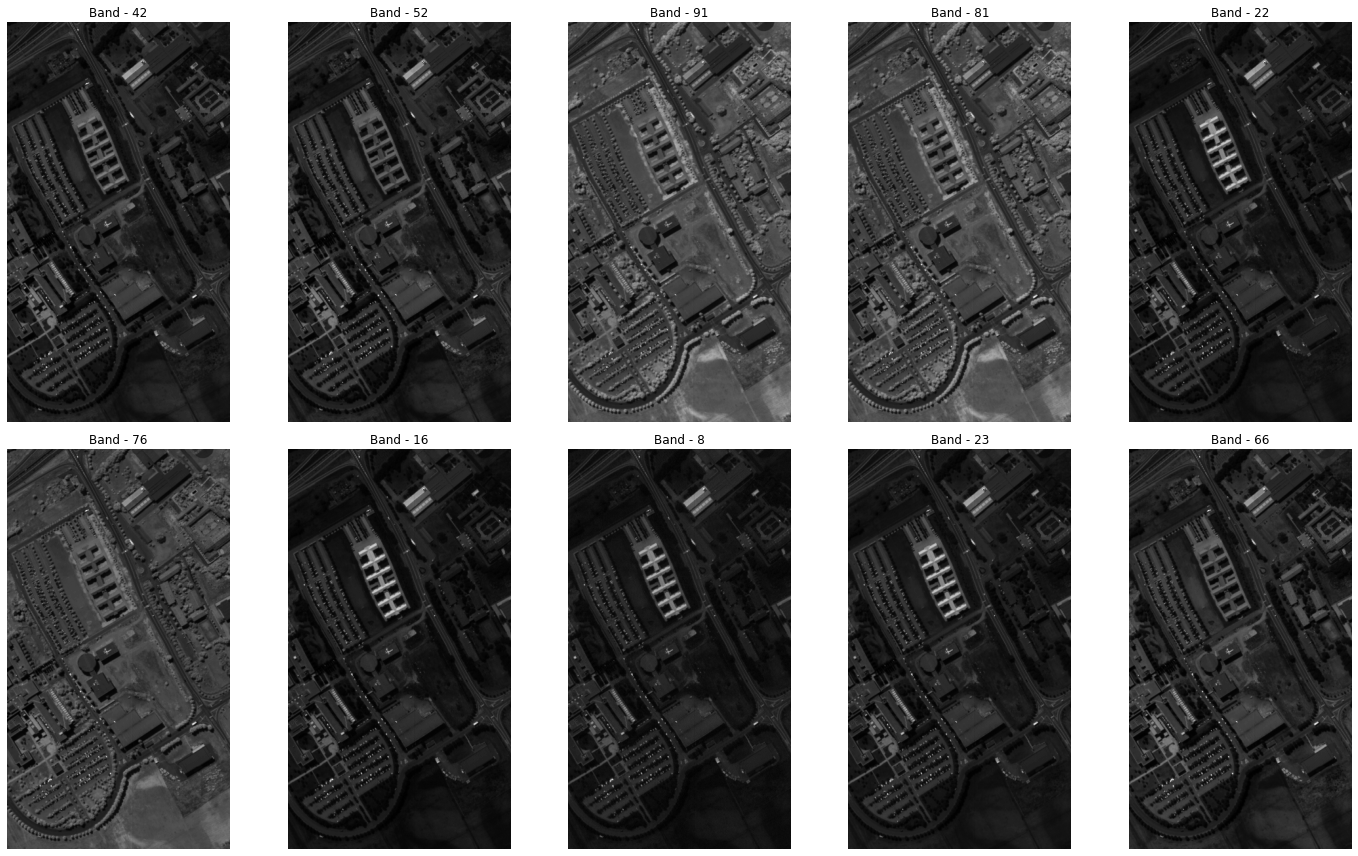

In [ ]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()


### Composite Image Visualization

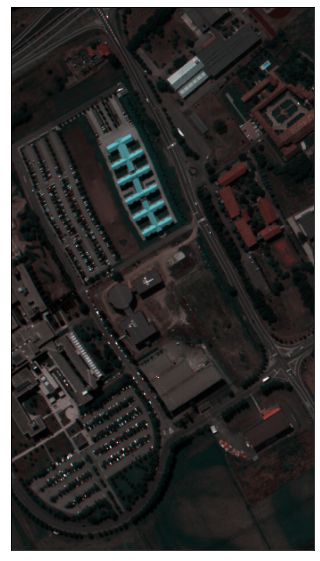

In [ ]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10)) 

plt.show()


## Ground Truth Visualization

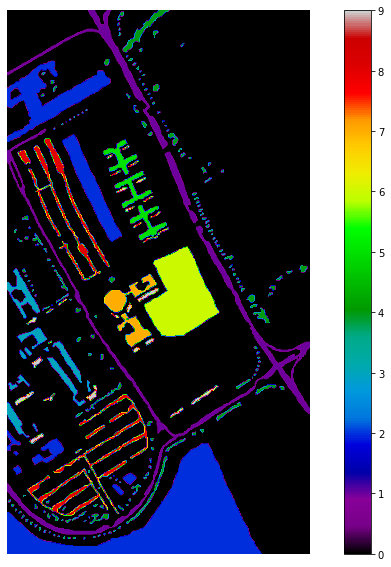

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [ ]:
X = df[df['class']!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")

Train Data: (29943, 103)
Test Data: (12833, 103)


In [ ]:
y_test.shape

(12833, 10)

## Classification

In [ ]:
model = Sequential(name='Pavia_University')

model.add(Input(shape = X_train[0].shape, name = 'Input_Layer'))

model.add(BatchNormalization(name = 'BatchNormalization'))

model.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))

model.add(Dropout(rate = 0.2, name = 'Dropout1',))

model.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))

model.add(Dropout(rate = 0.2, name = 'Dropout2'))

model.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))

model.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model.summary()

Model: "Pavia_University"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BatchNormalization (BatchNor (None, 103)               412       
_________________________________________________________________
Layer1 (Dense)               (None, 128)               13312     
_________________________________________________________________
Layer2 (Dense)               (None, 128)               16512     
_________________________________________________________________
Layer3 (Dense)               (None, 128)               16512     
_________________________________________________________________
Layer4 (Dense)               (None, 128)               16512     
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
Layer5 (Dense)               (None, 64)           

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)


In [ ]:
history = model.fit(x = X_train, 
          y = y_train,
          validation_data = (X_test, y_test), 
          epochs = 100,
          callbacks = [es, checkpoint])

Epoch 1/100
926/936 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.6959
Epoch 00001: val_loss improved from inf to 0.50241, saving model to Pavia_University_Model.h5
936/936 [==============================] - 5s 6ms/step - loss: 0.8314 - accuracy: 0.6966 - val_loss: 0.5024 - val_accuracy: 0.8043
Epoch 2/100
927/936 [============================>.] - ETA: 0s - loss: 0.5842 - accuracy: 0.7785
Epoch 00002: val_loss improved from 0.50241 to 0.49619, saving model to Pavia_University_Model.h5
936/936 [==============================] - 4s 4ms/step - loss: 0.5836 - accuracy: 0.7789 - val_loss: 0.4962 - val_accuracy: 0.7988
Epoch 3/100
927/936 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8047
Epoch 00003: val_loss improved from 0.49619 to 0.41151, saving model to Pavia_University_Model.h5
936/936 [==============================] - 4s 4ms/step - loss: 0.5187 - accuracy: 0.8046 - val_loss: 0.4115 - val_accuracy: 0.8235
Epoch 4/100
921/936 [=====

In [ ]:
loss, acc = model.evaluate(X_test, y_test)

print(f'Loss: {loss}\nAccuracy: {acc}')

402/402 [==============================] - 1s 2ms/step - loss: 0.1505 - accuracy: 0.9416
Loss: 0.15045131742954254
Accuracy: 0.9415569305419922


In [ ]:
pred = np.argmax(model.predict(X_test), axis=1)

In [ ]:
pred.shape

(12833,)

In [ ]:
hist = pd.DataFrame(data= history.history)
hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.831377,0.696624,0.502407,0.804333
1,0.583620,0.778913,0.496193,0.798800
2,0.518656,0.804629,0.411513,0.823502
3,0.467938,0.815817,0.349167,0.861841
4,0.446181,0.824400,0.339839,0.848360


In [ ]:
hist.to_csv('PU_train_data.csv')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [ ]:
from collections import Counter
Counter(np.argmax(y_test, 1)), Counter(pred)

(Counter({1: 1989,
          2: 5595,
          3: 630,
          4: 919,
          5: 403,
          6: 1509,
          7: 399,
          8: 1105,
          9: 284}),
 Counter({1: 1992,
          2: 5676,
          3: 636,
          4: 976,
          5: 403,
          6: 1396,
          7: 361,
          8: 1109,
          9: 284}))

In [ ]:
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']))

                         precision    recall  f1-score   support

             1. Asphalt       0.95      0.95      0.95      1992
             2. Meadows       0.98      0.97      0.98      5676
              3. Gravel       0.77      0.76      0.76       636
               4. Trees       0.98      0.93      0.95       976
5. Painted metal sheets       1.00      1.00      1.00       403
           6. Bare Soil       0.90      0.97      0.93      1396
             7. Bitumen       0.81      0.90      0.86       361
8. Self-Blocking Bricks       0.85      0.84      0.85      1109
             9. Shadows       1.00      1.00      1.00       284

               accuracy                           0.94     12833
              macro avg       0.92      0.92      0.92     12833
           weighted avg       0.94      0.94      0.94     12833



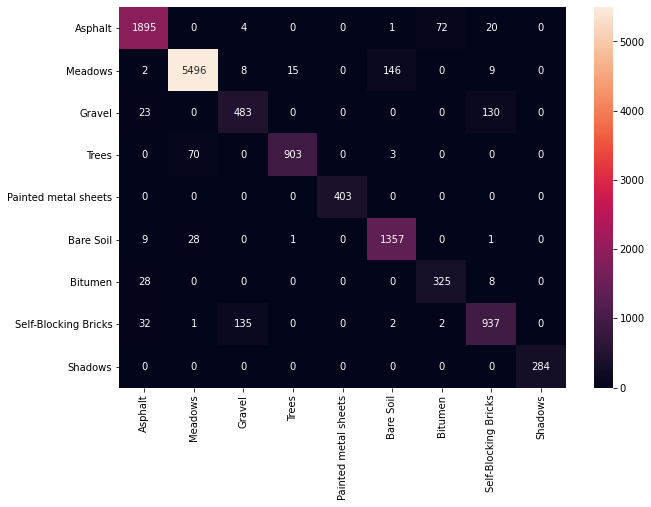

In [ ]:
plt.figure(figsize = (10,7))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes,
                  columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [ ]:
l = []

for i in tqdm(range(df.shape[0])):
  # print(data.shape, data.reshape(-1, 103).shape, data , sep='\n')
  if df.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 103)), 1))

100%|██████████| 207400/207400 [21:24<00:00, 161.45it/s]


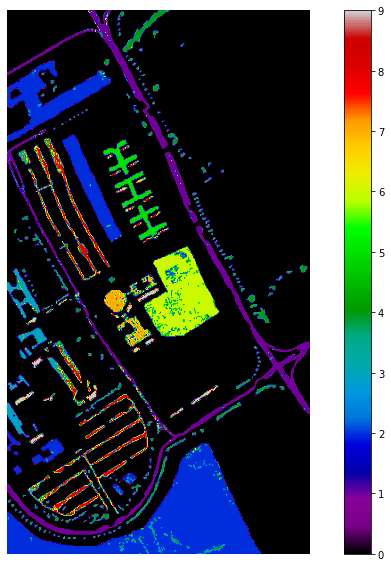

In [ ]:
q = np.array(l).reshape(gt.shape).astype('float')

plot_data(q)



---

